# Question 2

(1) Plot the return processes of the 11 selected sector ETFs and the S&P 500 index. Using a scree plot and by analyzing the eigenvalues of the correlation matrix, choose a sufficient number of factors.
(2) Upon finding the adequate number of factors, use the vari- max method to find a final rotated factor solution. Build a factor model to predict the S&P 500 stock index returns.
(3) Apply the factor sorting method on the most important fac- tor and design a long-short strategy for the 11 selected sec- tors where you put the neutral return stocks in the middle bucket and divide the positive and negative factor stocks evenly into other four buckets. In this, we assume a nor- mal distribution of the factor value, and we long the best performing bucket and short the worst performing bucket. Compare this strategy with the benchmark return of the S&P 500 stock index return.


In [67]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.api import OLS, add_constant
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris

import pandas_datareader as pdr
import pandas_datareader.data as web

from pprint import pprint
#import pyfolio as pf
#import quantstats as qs
from datetime import date
from pandas_datareader.famafrench import get_available_datasets
from scipy.stats import spearmanr, pearsonr


from pathlib import Path
import seaborn as sns 
#from linearmodels.asset_pricing import TradedFactorModel, LinearFactorModel, LinearFactorModelGMM
import yfinance as yf


In [68]:
#2.1
symbols = ['VOX', 'VCR', 'VDC', 'VDE', 'VFH', 'VHT', 'VIS', 'VGT', 'VAW', 'VNQ', 'VPU']
secs = ['COMM', 'CONSUMER DISC', 'CONSUMER ST', 'ENERGY', 'FINANCIALS', 'HEALTH', 'INDUSTRIALS', 
           'TECHNOLOGY', 'MATIREALS', 'REAL ESTATE', 'UTILITIES']

In [69]:
start = pd.Timestamp('2010-01-01')
end = pd.Timestamp('2020-12-31')

In [70]:
data = yf.download(symbols,start,end)['Adj Close']

[*********************100%***********************]  11 of 11 completed


In [71]:
data.head()

,VAW,VCR,VDC,VDE,VFH,VGT,VHT,VIS,VNQ,VOX,VPU
Date,,,,,,,,,,,
2010-01-04,55.568081,40.562344,48.437401,61.336548,22.878487,49.350788,46.237484,43.212273,27.234631,42.996925,42.782715
2010-01-05,55.902100,40.820473,48.481197,61.964382,23.133821,49.297722,45.951340,43.401443,27.204054,43.287434,42.384098
2010-01-06,56.689480,40.863487,48.473892,62.677849,23.172499,48.952789,46.212234,43.508366,27.155159,42.602104,42.573616
2010-01-07,56.442909,41.216286,48.473892,62.528019,23.621250,48.767063,46.372135,44.042965,27.448589,42.445671,42.384098
2010-01-08,57.055302,41.250698,48.211121,62.998898,23.528404,49.147358,46.540466,44.626911,27.246845,42.251987,42.338364


In [72]:
data.to_excel("ETF_adj_close.xlsx")
etf_returns=data.pct_change().dropna()
etf_returns.to_excel("etf_returns.xlsx")
etf_returns

,VAW,VCR,VDC,VDE,VFH,VGT,VHT,VIS,VNQ,VOX,VPU
Date,,,,,,,,,,,
2010-01-05,0.006011,0.006364,0.000904,0.010236,0.011160,-0.001075,-0.006189,0.004378,-0.001123,0.006756,-0.009317
2010-01-06,0.014085,0.001054,-0.000151,0.011514,0.001672,-0.006997,0.005678,0.002464,-0.001797,-0.015832,0.004471
2010-01-07,-0.004349,0.008634,0.000000,-0.002390,0.019366,-0.003794,0.003460,0.012287,0.010806,-0.003672,-0.004452
2010-01-08,0.010850,0.000835,-0.005421,0.007531,-0.003931,0.007798,0.003630,0.013259,-0.007350,-0.004563,-0.001079
2010-01-11,-0.003346,-0.001251,0.003482,-0.000792,-0.000329,-0.004319,0.005063,0.009399,0.005834,0.000882,0.007717
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,0.002788,0.000847,0.004158,0.025341,0.016456,-0.009102,0.001309,0.005703,-0.006468,0.006795,-0.001724
2020-12-24,0.005366,0.001949,0.004257,-0.008365,0.000419,0.006647,0.001397,0.000650,0.008755,0.000675,0.006009
2020-12-28,-0.004051,0.008002,0.006504,-0.007285,0.003767,0.007028,-0.002971,-0.000531,0.005961,0.012478,0.005674


In [73]:
## do the same, to obtain SPY returns
spy = yf.download(['SPY'],start,end)['Adj Close']
spy_returns=spy.pct_change().dropna()  ## get returns from price, and drop NaN values

spy_returns.head()

[*********************100%***********************]  1 of 1 completed


Date
2010-01-05    0.002648
2010-01-06    0.000704
2010-01-07    0.004221
2010-01-08    0.003327
2010-01-11    0.001397
Name: Adj Close, dtype: float64

In [74]:
sp=pd.Series(spy)
sp

Date
2010-01-04     88.860344
2010-01-05     89.095612
2010-01-06     89.158340
2010-01-07     89.534706
2010-01-08     89.832626
                 ...    
2020-12-23    358.583099
2020-12-24    359.978088
2020-12-28    363.070648
2020-12-29    362.377960
2020-12-30    362.895020
Name: Adj Close, Length: 2768, dtype: float64

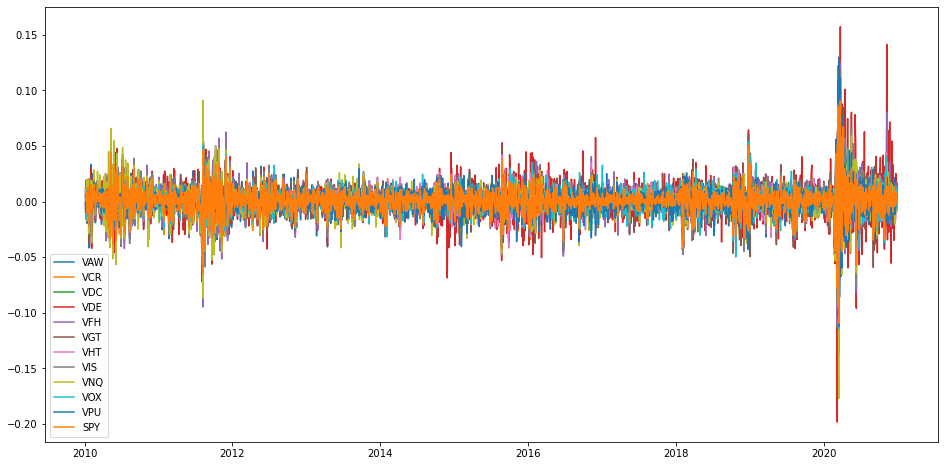

In [75]:
plt.figure(figsize=(16,8))
## plot the return process of 11 ETFs and SPY
for col in etf_returns.columns:
    plt.plot(etf_returns[col], label = col)
plt.plot(spy_returns, label='SPY')
plt.legend()
plt.show()

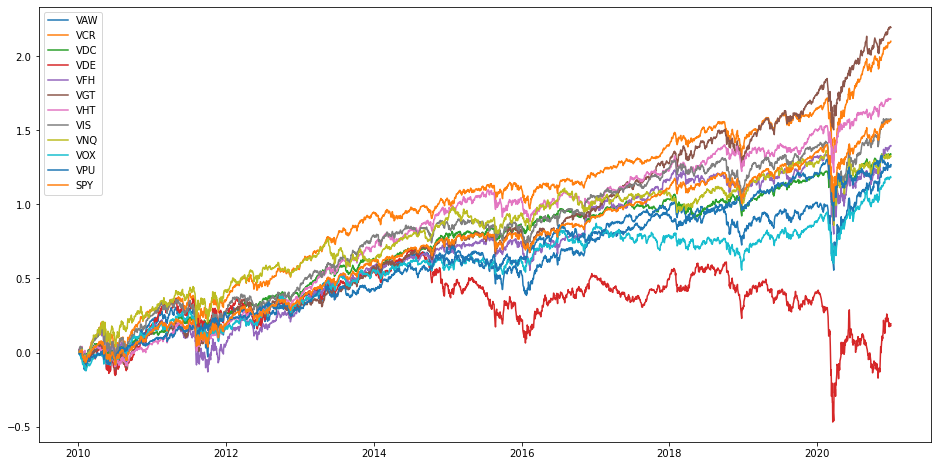

In [76]:
plt.figure(figsize=(16,8))
## plot the return process of 11 ETFs and SPY
for col in etf_returns.columns:
    plt.plot(etf_returns[col].cumsum(), label = col)
plt.plot(spy_returns.cumsum(), label='SPY')
plt.legend()
plt.show()

In [77]:
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
chi_square_value,p_value=calculate_bartlett_sphericity(etf_returns)
chi_square_value, p_value

(37062.60798504612, 0.0)

In [78]:
# Kaiser-Meyer-Olkin (KMO) Test measures the suitability of data for factor analysis. 
# It determines the adequacy for each observed variable and for the complete model. 
# KMO estimates the proportion of variance among all the observed variable. Lower proportion id 
# more suitable for factor analysis. KMO values range between 0 and 1. Value of KMO less than 0.6 
# is considered inadequate.
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(etf_returns)
kmo_model

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.9471786271710523

In [79]:
## perfrom factor analysis using FactorAnalyzer
fa = FactorAnalyzer(n_factors=13, rotation=None) # factor analysis object
fa.fit(etf_returns)
ev, v = fa.get_eigenvalues() # eigenvalues
ev 

array([8.28271473, 0.77087092, 0.51717673, 0.29609469, 0.2796993 ,
       0.2016659 , 0.19410103, 0.16009365, 0.13257699, 0.0991743 ,
       0.06583176])

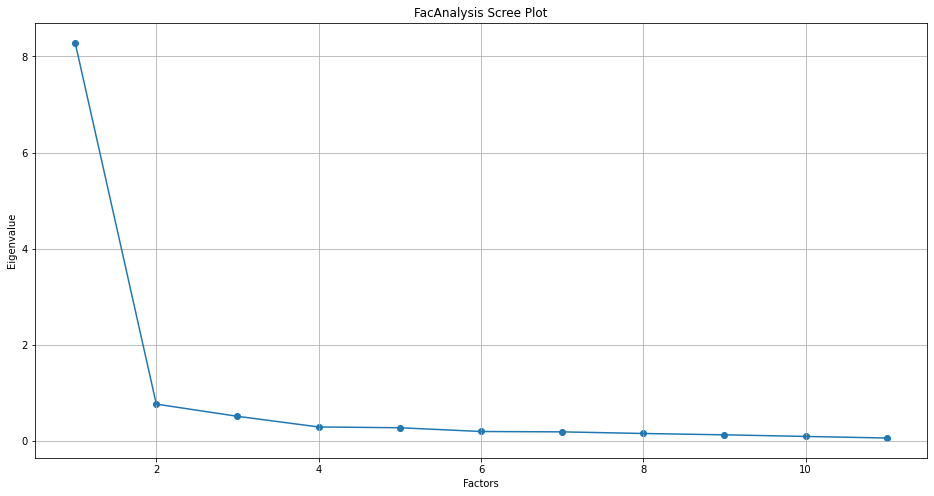

In [80]:
plt.figure(figsize=(16,8))
# Create scree plot using matplotlib
plt.scatter(range(1,len(ev)+1),ev)
plt.plot(range(1,len(ev)+1),ev)
plt.title('FacAnalysis Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [81]:
#2.2

df=pd.read_excel('etf_returns.xlsx')

In [82]:
df.head()

,Date,VAW,VCR,VDC,VDE,VFH,VGT,VHT,VIS,VNQ,VOX,VPU
0,2010-01-05,0.006011,0.006364,0.000904,0.010236,0.011160,-0.001075,-0.006189,0.004378,-0.001123,0.006756,-0.009317
1,2010-01-06,0.014085,0.001054,-0.000151,0.011514,0.001672,-0.006997,0.005678,0.002464,-0.001797,-0.015832,0.004471
2,2010-01-07,-0.004349,0.008634,0.000000,-0.002390,0.019366,-0.003794,0.003460,0.012287,0.010806,-0.003672,-0.004452
3,2010-01-08,0.010850,0.000835,-0.005421,0.007531,-0.003931,0.007798,0.003630,0.013259,-0.007350,-0.004563,-0.001079
4,2010-01-11,-0.003346,-0.001251,0.003482,-0.000792,-0.000329,-0.004319,0.005063,0.009399,0.005834,0.000882,0.007717


In [83]:
len(df)

2767

In [84]:
SPY = web.DataReader('SPY', 'yahoo', start, end)
a=SPY['Adj Close'].pct_change().dropna() 
a.columns=['Date','Return']
#a.to_excel('SPY.xlsx')
dfSPY=pd.read_excel('SPY.xlsx')
dfSPY['Adj Close']


0       0.002647
1       0.000704
2       0.004221
3       0.003328
4       0.001396
          ...   
2763    0.003890
2764    0.008591
2765   -0.001908
2766    0.001427
2767    0.005081
Name: Adj Close, Length: 2768, dtype: float64

In [85]:
a.iloc[1]

0.0007040625918666166

In [86]:
fa = FactorAnalyzer(n_factors=2, rotation="varimax")
fa.fit(etf_returns)

new_data = pd.DataFrame(fa.transform(etf_returns),columns=['Factor1','Factor2'])
new_data['SPY']=dfSPY['Adj Close']
new_data.head()

,Factor1,Factor2,SPY
0,0.821316,-0.979295,0.002647
1,0.032356,0.163167,0.000704
2,0.724313,-0.448907,0.004221
3,0.711076,-0.638957,0.003328
4,-0.158257,0.651582,0.001396


In [87]:
import statsmodels.api as sm
from statsmodels.api import OLS, add_constant

## regression 'SPY ~ Factor1, Factor2'
reg = OLS(new_data.SPY, new_data[['Factor1', 'Factor2']]).fit().params
## add the predicted index to new_data
## predict ~ Factor1, Factor2
new_data['predict']=new_data.Factor1*reg.Factor1+new_data.Factor2*reg.Factor2
new_data[['SPY','predict']].head()

,SPY,predict
0,0.002647,0.002699
1,0.000704,0.001153
2,0.004221,0.004532
3,0.003328,0.003421
4,0.001396,0.001882


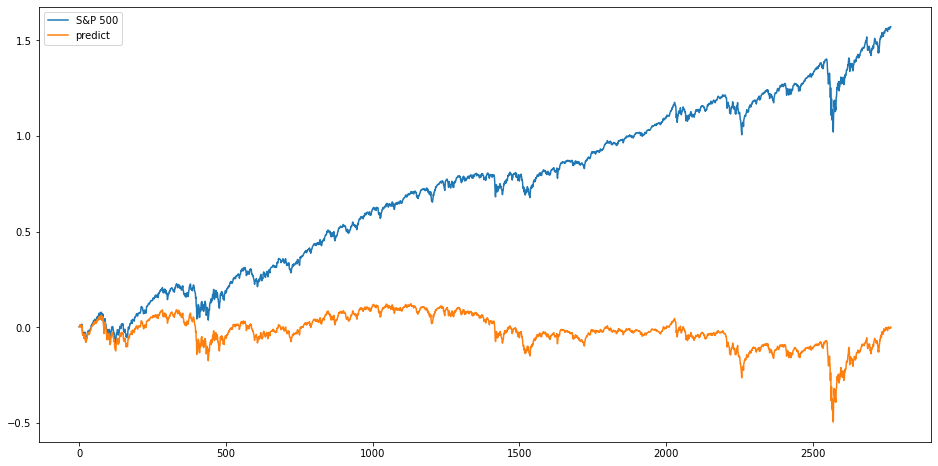

In [88]:
plt.figure(figsize=(16,8))
plt.plot(new_data.SPY.cumsum(),label='S&P 500')
plt.plot(new_data.predict.cumsum(),label='predict')
plt.legend()
plt.show()

In [89]:
#2.3

fa = FactorAnalyzer(n_factors=2, rotation="varimax")

loadings = pd.DataFrame(fa.fit(etf_returns).loadings_,columns=['Factor1','Factor2'])
loadings.index = etf_returns.columns
print(loadings)


      Factor1   Factor2
VAW  0.848783  0.368389
VCR  0.857187  0.372095
VDC  0.564538  0.661347
VDE  0.728019  0.297289
VFH  0.813571  0.406731
VGT  0.809353  0.359871
VHT  0.722191  0.453260
VIS  0.875132  0.395685
VNQ  0.562748  0.638739
VOX  0.716569  0.431419
VPU  0.271676  0.908935


In [90]:
loadings.sort_values(by=['Factor1'])

,Factor1,Factor2
VPU,0.271676,0.908935
VNQ,0.562748,0.638739
VDC,0.564538,0.661347
VOX,0.716569,0.431419
VHT,0.722191,0.453260
VDE,0.728019,0.297289
VGT,0.809353,0.359871
VFH,0.813571,0.406731
VAW,0.848783,0.368389
VCR,0.857187,0.372095


In [91]:
dic_sym={symbols[i]: secs[i] for i in range(len(symbols))}

In [92]:
t_symbols=['VIS','VCR','VNQ','VPU']  ## top two and bottom two secs by loadings of Factor1

In [93]:
## out of sample test
start = pd.Timestamp('2010-01-01')
end=pd.Timestamp('2020-12-31')
data_source = 'yahoo'

In [94]:
t_prices = yf.download(t_symbols,start,end)['Adj Close']
t_prices.head()

[*********************100%***********************]  4 of 4 completed


,VCR,VIS,VNQ,VPU
Date,,,,
2010-01-04,40.562336,43.212276,27.234629,42.782722
2010-01-05,40.820473,43.401443,27.204062,42.384106
2010-01-06,40.863503,43.508369,27.155151,42.573612
2010-01-07,41.216278,44.042957,27.448593,42.384106
2010-01-08,41.250710,44.626907,27.246841,42.338371


In [95]:
t_returns = t_prices.pct_change().dropna()
t_returns.head()

,VCR,VIS,VNQ,VPU
Date,,,,
2010-01-05,0.006364,0.004378,-0.001122,-0.009317
2010-01-06,0.001054,0.002464,-0.001798,0.004471
2010-01-07,0.008633,0.012287,0.010806,-0.004451
2010-01-08,0.000835,0.013259,-0.007350,-0.001079
2010-01-11,-0.001252,0.009399,0.005834,0.007717


In [96]:
## long the first two, short the last two
t_returns['Long']= t_returns[['VIS','VCR']].sum(axis=1)/2
t_returns['short']= -1*t_returns[['VPU','VNQ']].sum(axis=1)/2
t_returns['Portfolio']= t_returns[['Long','short']].sum(axis=1)
t_returns.head()

,VCR,VIS,VNQ,VPU,Long,short,Portfolio
Date,,,,,,,
2010-01-05,0.006364,0.004378,-0.001122,-0.009317,0.005371,0.005220,0.010591
2010-01-06,0.001054,0.002464,-0.001798,0.004471,0.001759,-0.001337,0.000422
2010-01-07,0.008633,0.012287,0.010806,-0.004451,0.010460,-0.003177,0.007283
2010-01-08,0.000835,0.013259,-0.007350,-0.001079,0.007047,0.004215,0.011262
2010-01-11,-0.001252,0.009399,0.005834,0.007717,0.004074,-0.006775,-0.002702


In [97]:
cum_returns = t_returns.cumsum()
cum_returns.tail(3)

,VCR,VIS,VNQ,VPU,Long,short,Portfolio
Date,,,,,,,
2020-12-28,2.098319,1.575101,1.329055,1.264675,1.836710,-1.296865,0.539845
2020-12-29,2.096207,1.568486,1.320523,1.262596,1.832347,-1.291559,0.540787
2020-12-30,2.101936,1.575205,1.326021,1.268845,1.838570,-1.297433,0.541137


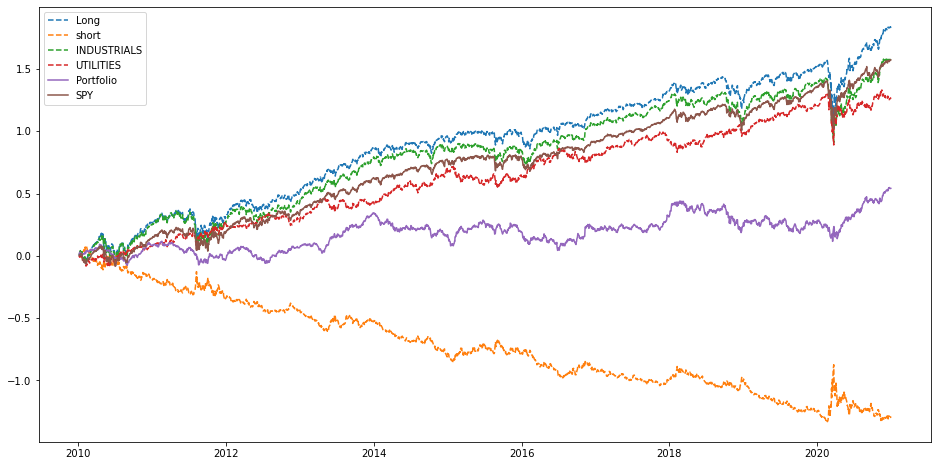

In [98]:
## plot 
plt.figure(figsize=(16,8))
plt.plot(cum_returns.index,cum_returns.Long, label='Long', linestyle='dashed')
plt.plot(cum_returns.index,cum_returns.short, label='short', linestyle='dashed')
plt.plot(cum_returns.index,cum_returns.VIS, label=dic_sym.get('VIS'), linestyle='dashed')
plt.plot(cum_returns.index,cum_returns.VPU, label=dic_sym.get('VPU'), linestyle='dashed')
plt.plot(cum_returns.index,cum_returns.Portfolio, label='Portfolio')
plt.plot(spy_returns.cumsum(), label='SPY')
plt.legend()
plt.show()

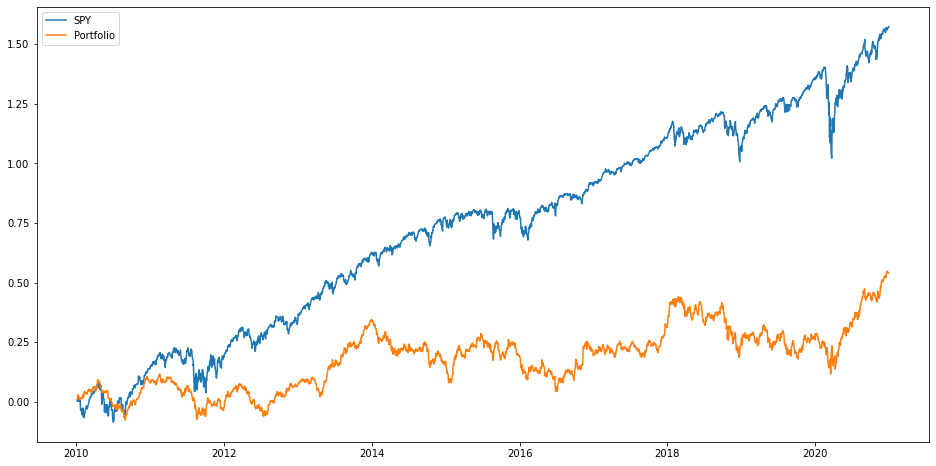

In [99]:
plt.figure(figsize=(16,8))
plt.plot(spy_returns.cumsum(), label='SPY')
plt.plot(cum_returns.index,cum_returns.Portfolio, label='Portfolio')
plt.legend()

In [100]:
portfolio_return = t_returns[['Long','short']].sum(axis=1)
portfolio_return.head()

Date
2010-01-05    0.010591
2010-01-06    0.000422
2010-01-07    0.007283
2010-01-08    0.011262
2010-01-11   -0.002702
dtype: float64

In [101]:
sharpe_ratio = (252**0.5)*t_returns.Portfolio.mean()/t_returns.Portfolio.std()
sharpe_ratio

0.3636633460781713